In [289]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier, SGDRegressor
import lightgbm as lgb
from matplotlib import pyplot as plt
import joblib
from pathlib import Path
import sqlite3

In [290]:
pd.options.display.max_rows=100
pd.options.display.max_columns=50

In [291]:
def create_results_df():
    
    path_to_results = Path().home().joinpath('NBA_Model_v1', 'results', 'betting_predictions_2022.csv')
    path_to_db = Path.home().joinpath('NBA_Model_v1', 'data', 'nba.db')
    season = '2022-23'
        
    preds = pd.read_csv(path_to_results)
    preds = preds.drop_duplicates(subset=['home_team', 'away_team', 'game_date'], keep='last')

    connection = sqlite3.connect(path_to_db)
    scores = pd.read_sql(f"""SELECT a.SEASON
                            ,a.GAME_DATE
                            ,a.TEAM_ABBREVIATION AS HOME_TEAM_ABBREVIATION
                            ,b.TEAM_ABBREVIATION AS AWAY_TEAM_ABBREVIATION
                            ,a.PTS AS HOME_TEAM_SCORE
                            ,b.PTS AS AWAY_TEAM_SCORE 
                        FROM team_basic_boxscores a
                        JOIN team_basic_boxscores b
                        ON a.GAME_ID = b.GAME_ID
                        WHERE a.MATCHUP like '%vs%'
                        and a.TEAM_ABBREVIATION != b.TEAM_ABBREVIATION
                        and a.SEASON = '{season}'""", con = connection)

    scores['GAME_DATE'] = pd.to_datetime(scores['GAME_DATE']).astype(str)

    merged = pd.merge(preds, scores, how='left', 
                    left_on = ['home_team', 'game_date'],
                    right_on = ['HOME_TEAM_ABBREVIATION', 'GAME_DATE'])
    
    

    merged['SGD_ATS_DIFF'] = merged['sgd_home_score_pred'] - merged['sgd_away_score_pred'] + merged['home_spread']
    merged['LGB_ATS_DIFF'] = merged['lgb_home_score_pred'] - merged['lgb_away_score_pred'] + merged['home_spread']

    merged['SGD_ATS_BET_HOME'] = (merged['SGD_ATS_DIFF']>0).astype(int)
    merged['LGB_ATS_BET_HOME'] = (merged['LGB_ATS_DIFF']>0).astype(int)

    merged['HOME_SCORE_DIFF'] = merged['HOME_TEAM_SCORE'] - merged['AWAY_TEAM_SCORE']
    merged['HOME_WIN'] = (merged['HOME_SCORE_DIFF']>0).astype(int)

    merged['HOME_COVER'] = ((merged['HOME_SCORE_DIFF'] + merged['home_spread']) > 0).astype(int)
    
    condlist = [merged['home_spread'] < 0
                ,merged['home_spread'] > 0]
    choicelist = [((merged['HOME_SCORE_DIFF'] + merged['home_spread']) > 0).astype(int)
                  ,((-merged['HOME_SCORE_DIFF'] + -merged['home_spread']) > 0).astype(int)]
    
    merged['FAVORITE_COVER'] = np.select(condlist, choicelist, np.nan)
    
    merged.loc[(merged['HOME_SCORE_DIFF'] + merged['home_spread']) == 0, 'HOME_COVER'] = np.nan

    merged['SGD_ATS_BET_RESULT'] = (merged['HOME_COVER'] == merged['SGD_ATS_BET_HOME']).astype(int)
    merged['LGB_ATS_BET_RESULT'] = (merged['HOME_COVER'] == merged['LGB_ATS_BET_HOME']).astype(int)


    merged['SGD_HINGE_ML_BET_RESULT'] = (merged['home_win_prob_sgd_hinge'] == merged['HOME_WIN']).astype(int)
    merged['SGD_LOGLOSS_ML_BET_RESULT'] = (merged['home_win_prob_sgd_logloss'].round() == merged['HOME_WIN']).astype(int)
    merged['LGB_ML_BET_RESULT'] = (merged['home_win_prob_lgbc'].round() == merged['HOME_WIN']).astype(int)


    merged.loc[merged['HOME_SCORE_DIFF'].isnull(), ['HOME_WIN', 'HOME_COVER', 'SGD_ATS_BET_RESULT',
                                                    'LGB_ATS_BET_RESULT', 'SGD_HINGE_ML_BET_RESULT',
                                                    'SGD_LOGLOSS_ML_BET_RESULT', 'LGB_ML_BET_RESULT']] = np.nan


    merged = merged.drop(columns = ['GAME_DATE', 'SEASON', 'HOME_TEAM_ABBREVIATION'])
    
    return merged

In [292]:
results = create_results_df()

results

,home_team,away_team,game_date,home_spread,home_moneylines,away_moneylines,sgd_home_score_pred,sgd_away_score_pred,lgb_home_score_pred,lgb_away_score_pred,home_win_prob_sgd_hinge,home_win_prob_sgd_logloss,away_win_prob_sgd_logloss,home_win_prob_lgbc,away_win_prob_lgbc,AWAY_TEAM_ABBREVIATION,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,SGD_ATS_DIFF,LGB_ATS_DIFF,SGD_ATS_BET_HOME,LGB_ATS_BET_HOME,HOME_SCORE_DIFF,HOME_WIN,HOME_COVER,FAVORITE_COVER,SGD_ATS_BET_RESULT,LGB_ATS_BET_RESULT,SGD_HINGE_ML_BET_RESULT,SGD_LOGLOSS_ML_BET_RESULT,LGB_ML_BET_RESULT
0,DET,ORL,2022-10-19,-3.0,1.689655,2.250000,113.409544,111.058845,107.903390,108.971230,1,0.623637,0.376363,0.487241,0.512759,ORL,113.0,109.0,-0.649301,-4.067840,0,0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
1,IND,WAS,2022-10-19,1.0,1.952381,1.869565,115.204471,116.127576,115.438471,114.960548,1,0.462378,0.537622,0.359084,0.640916,WAS,107.0,114.0,0.076895,1.477923,1,1,-7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,BKN,NOP,2022-10-19,-3.0,1.666667,2.300000,110.883008,108.779141,111.617561,105.747313,0,0.707338,0.292662,0.545411,0.454589,NOP,108.0,130.0,-0.896133,2.870248,0,1,-22.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,MEM,NYK,2022-10-19,-4.0,1.571429,2.500000,104.937682,109.503584,106.732776,105.929732,0,0.396311,0.603689,0.392375,0.607625,NYK,115.0,112.0,-8.565902,-3.196956,0,0,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,ATL,HOU,2022-10-19,-9.5,1.222222,4.600000,115.801929,110.365446,116.699032,108.988385,1,0.730860,0.269140,0.794196,0.205804,HOU,117.0,107.0,-4.063517,-1.789354,0,0,10.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,HOU,DET,2023-03-31,-5.5,1.476190,2.800000,119.454035,113.128450,116.985299,107.698871,1,0.767269,0.232731,0.693309,0.306691,NaN,NaN,NaN,0.825585,3.786428,1,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1151,MIN,LAL,2023-03-31,1.0,1.952381,1.869565,110.124965,112.404182,112.451963,114.651075,0,0.346353,0.653647,0.435636,0.564364,NaN,NaN,NaN,-1.279217,-1.199111,0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1152,MEM,LAC,2023-03-31,-6.5,1.363636,3.300000,117.096040,116.011302,120.550764,115.778610,1,0.598644,0.401356,0.656033,0.343967,NaN,NaN,NaN,-5.415263,-1.727846,0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1153,POR,SAC,2023-03-31,14.5,8.000000,1.095238,107.788252,122.343657,104.743256,121.641771,0,0.132320,0.867680,0.206057,0.793943,NaN,NaN,NaN,-0.055406,-2.398515,0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [293]:
results[['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'home_spread', 'FAVORITE_COVER']]

,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,home_spread,FAVORITE_COVER
0,113.0,109.0,-3.0,1.0
1,107.0,114.0,1.0,1.0
2,108.0,130.0,-3.0,0.0
3,115.0,112.0,-4.0,0.0
4,117.0,107.0,-9.5,1.0
...,...,...,...,...
1150,NaN,NaN,-5.5,0.0
1151,NaN,NaN,1.0,0.0
1152,NaN,NaN,-6.5,0.0
1153,NaN,NaN,14.5,0.0


In [294]:
results['home_score_err'] = results['sgd_home_score_pred'] - results['HOME_TEAM_SCORE']
results['away_score_err'] = results['sgd_away_score_pred'] - results['AWAY_TEAM_SCORE']

results['implied_home_win_prob'] = 1/results['home_moneylines']


<AxesSubplot: >

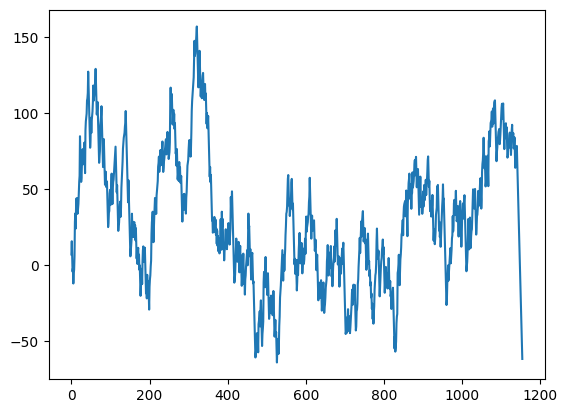

In [295]:
def simulate_ml_bets_all(results, bet_amt):
    results = results.copy(deep=True)
    results['bankroll_n'] = np.nan
    results['bankroll_i'] = np.nan
    results['bet_size'] = 10

    results.loc[0, 'bankroll_i'] = 0
    for i, row in results.iterrows():
        if row['home_win_prob_sgd_logloss'] > 0.5: 
            # results.at[i, 'bet_size'] = bet_amt / (row['home_moneylines'] - 1)
            if row['SGD_LOGLOSS_ML_BET_RESULT'] == 1:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] +  (results.at[i, 'bet_size'] * (results.at[i, 'home_moneylines']-1))
            else:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] - results.at[i, 'bet_size']
            results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n'] 
        elif row['home_win_prob_sgd_logloss'] < 0.5: 
            # results.at[i, 'bet_size'] = bet_amt / (row['away_moneylines'] - 1)
            if row['SGD_LOGLOSS_ML_BET_RESULT'] == 1:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] + (results.at[i, 'bet_size'] * (results.at[i, 'away_moneylines']-1))
            else:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] - results.at[i, 'bet_size']
            results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n'] 
 
    return results            

bet_results = simulate_ml_bets_all(results, bet_amt=10)
bet_results['bankroll_n'].plot()

In [296]:
bet_results[['home_team', 'away_team', 'game_date', 'home_moneylines', 
            'away_moneylines', 'HOME_WIN', 'HOME_COVER', 'implied_home_win_prob',
            'home_win_prob_sgd_logloss', 'SGD_LOGLOSS_ML_BET_RESULT', 'bankroll_i', 'bet_size', 'bankroll_n',
            ]]

,home_team,away_team,game_date,home_moneylines,away_moneylines,HOME_WIN,HOME_COVER,implied_home_win_prob,home_win_prob_sgd_logloss,SGD_LOGLOSS_ML_BET_RESULT,bankroll_i,bet_size,bankroll_n
0,DET,ORL,2022-10-19,1.689655,2.250000,1.0,1.0,0.591837,0.623637,1.0,0.000000,10.0,6.896552
1,IND,WAS,2022-10-19,1.952381,1.869565,0.0,0.0,0.512195,0.462378,1.0,6.896552,10.0,15.592204
2,BKN,NOP,2022-10-19,1.666667,2.300000,0.0,0.0,0.600000,0.707338,0.0,15.592204,10.0,5.592204
3,MEM,NYK,2022-10-19,1.571429,2.500000,1.0,0.0,0.636364,0.396311,0.0,5.592204,10.0,-4.407796
4,ATL,HOU,2022-10-19,1.222222,4.600000,1.0,1.0,0.818182,0.730860,1.0,-4.407796,10.0,-2.185574
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,MIN,LAL,2023-03-31,1.952381,1.869565,NaN,NaN,0.512195,0.346353,NaN,-21.765778,10.0,-31.765778
1152,MEM,LAC,2023-03-31,1.363636,3.300000,NaN,NaN,0.733333,0.598644,NaN,-31.765778,10.0,-41.765778
1153,POR,SAC,2023-03-31,8.000000,1.095238,NaN,NaN,0.125000,0.132320,NaN,-41.765778,10.0,-51.765778
1154,PHX,DEN,2023-03-31,1.235294,4.400000,NaN,NaN,0.809524,0.687813,NaN,-51.765778,10.0,-61.765778


In [297]:
def simulate_ml_bets(results, bet_amt):
    results = results.copy(deep=True)
    results['bankroll_n'] = np.nan
    results['bankroll_i'] = np.nan

    results.loc[0, 'bankroll_i'] = 0
    for i, row in results.iterrows():
        if (row['home_win_prob_sgd_logloss'] > row['implied_home_win_prob']) and row['home_win_prob_sgd_logloss'] > 0.5:
            if row['HOME_WIN'] == 1:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] + (bet_amt) * (results.at[i, 'home_moneylines']-1)
            else:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] - bet_amt
            results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n']

        elif (row['home_win_prob_sgd_logloss'] < row['implied_home_win_prob']) and row['home_win_prob_sgd_logloss'] < 0.5:
            if row['HOME_WIN'] == 0:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] + (bet_amt) * (results.at[i, 'away_moneylines']-1)
            else:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] - bet_amt
            results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n']
        else:
            results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i']
            results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n']
        
    return results            

bet_results = simulate_ml_bets(results, bet_amt=10)

In [298]:
bet_results[['home_team', 'away_team', 'game_date', 'home_moneylines', 
            'away_moneylines', 'HOME_WIN', 'HOME_COVER', 'implied_home_win_prob',
            'home_win_prob_sgd_logloss', 'SGD_LOGLOSS_ML_BET_RESULT', 'bankroll_i', 'bankroll_n',
            ]]

,home_team,away_team,game_date,home_moneylines,away_moneylines,HOME_WIN,HOME_COVER,implied_home_win_prob,home_win_prob_sgd_logloss,SGD_LOGLOSS_ML_BET_RESULT,bankroll_i,bankroll_n
0,DET,ORL,2022-10-19,1.689655,2.250000,1.0,1.0,0.591837,0.623637,1.0,0.000000,6.896552
1,IND,WAS,2022-10-19,1.952381,1.869565,0.0,0.0,0.512195,0.462378,1.0,6.896552,15.592204
2,BKN,NOP,2022-10-19,1.666667,2.300000,0.0,0.0,0.600000,0.707338,0.0,15.592204,5.592204
3,MEM,NYK,2022-10-19,1.571429,2.500000,1.0,0.0,0.636364,0.396311,0.0,5.592204,-4.407796
4,ATL,HOU,2022-10-19,1.222222,4.600000,1.0,1.0,0.818182,0.730860,1.0,-4.407796,-4.407796
...,...,...,...,...,...,...,...,...,...,...,...,...
1151,MIN,LAL,2023-03-31,1.952381,1.869565,NaN,NaN,0.512195,0.346353,NaN,78.593491,68.593491
1152,MEM,LAC,2023-03-31,1.363636,3.300000,NaN,NaN,0.733333,0.598644,NaN,68.593491,68.593491
1153,POR,SAC,2023-03-31,8.000000,1.095238,NaN,NaN,0.125000,0.132320,NaN,68.593491,68.593491
1154,PHX,DEN,2023-03-31,1.235294,4.400000,NaN,NaN,0.809524,0.687813,NaN,68.593491,68.593491


<AxesSubplot: >

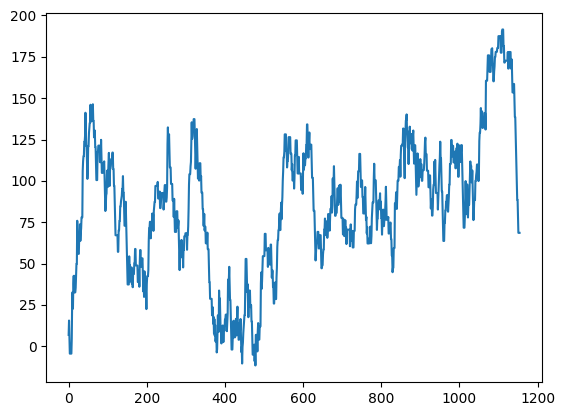

In [299]:
bet_results['bankroll_n'].plot()

In [300]:
bet_results.loc[((bet_results['home_win_prob_sgd_logloss'] > bet_results['implied_home_win_prob']) & (bet_results['home_win_prob_sgd_logloss'] > 0.5))
                | ((bet_results['home_win_prob_sgd_logloss'] < bet_results['implied_home_win_prob']) & (bet_results['home_win_prob_sgd_logloss'] < 0.5)), 'SGD_LOGLOSS_ML_BET_RESULT'].mean()



0.5880640465793304

In [301]:
bet_results.loc[((bet_results['home_win_prob_sgd_logloss'] < bet_results['implied_home_win_prob']) & bet_results['home_win_prob_sgd_logloss'] < 0.5)]

,home_team,away_team,game_date,home_spread,home_moneylines,away_moneylines,sgd_home_score_pred,sgd_away_score_pred,lgb_home_score_pred,lgb_away_score_pred,home_win_prob_sgd_hinge,home_win_prob_sgd_logloss,away_win_prob_sgd_logloss,home_win_prob_lgbc,away_win_prob_lgbc,AWAY_TEAM_ABBREVIATION,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,SGD_ATS_DIFF,LGB_ATS_DIFF,SGD_ATS_BET_HOME,LGB_ATS_BET_HOME,HOME_SCORE_DIFF,HOME_WIN,HOME_COVER,FAVORITE_COVER,SGD_ATS_BET_RESULT,LGB_ATS_BET_RESULT,SGD_HINGE_ML_BET_RESULT,SGD_LOGLOSS_ML_BET_RESULT,LGB_ML_BET_RESULT,home_score_err,away_score_err,implied_home_win_prob,bankroll_n,bankroll_i
0,DET,ORL,2022-10-19,-3.0,1.689655,2.250000,113.409544,111.058845,107.903390,108.971230,1.0,0.623637,0.376363,0.487241,0.512759,ORL,113.0,109.0,-0.649301,-4.067840,0.0,0.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.409544,2.058845,0.591837,6.896552,0.000000
2,BKN,NOP,2022-10-19,-3.0,1.666667,2.300000,110.883008,108.779141,111.617561,105.747313,0.0,0.707338,0.292662,0.545411,0.454589,NOP,108.0,130.0,-0.896133,2.870248,0.0,1.0,-22.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.883008,-21.220859,0.600000,5.592204,15.592204
9,UTA,DEN,2022-10-19,7.0,3.250000,1.377358,109.031661,108.730047,110.424503,106.791883,1.0,0.673097,0.326903,0.706642,0.293358,DEN,123.0,102.0,7.301614,10.632620,1.0,1.0,21.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,-13.968339,6.730047,0.307692,27.183113,4.683113
10,PHX,DAL,2022-10-19,-4.5,1.555556,2.550000,107.119173,100.490667,107.051972,101.748390,1.0,0.799160,0.200840,0.590172,0.409828,DAL,107.0,105.0,2.128506,0.803582,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.119173,-4.509333,0.642857,32.738669,27.183113
11,SAC,POR,2022-10-19,-3.0,1.689655,2.250000,113.834147,108.141336,113.752078,104.294503,1.0,0.720017,0.279983,0.679756,0.320244,POR,108.0,115.0,2.692811,6.457575,1.0,1.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.834147,-6.858664,0.591837,22.738669,32.738669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,BKN,ATL,2023-03-31,1.0,1.952381,1.869565,115.704061,114.466303,117.686716,114.692687,1.0,0.519622,0.480378,0.511878,0.488122,NaN,NaN,NaN,2.237758,3.994029,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512195,98.593491,108.593491
1148,CLE,NYK,2023-03-31,-3.5,1.588235,2.450000,111.976948,109.531217,113.081440,113.370768,1.0,0.684054,0.315946,0.569467,0.430533,NaN,NaN,NaN,-1.054268,-3.789327,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629630,88.593491,98.593491
1150,HOU,DET,2023-03-31,-5.5,1.476190,2.800000,119.454035,113.128450,116.985299,107.698871,1.0,0.767269,0.232731,0.693309,0.306691,NaN,NaN,NaN,0.825585,3.786428,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.677419,78.593491,88.593491
1153,POR,SAC,2023-03-31,14.5,8.000000,1.095238,107.788252,122.343657,104.743256,121.641771,0.0,0.132320,0.867680,0.206057,0.793943,NaN,NaN,NaN,-0.055406,-2.398515,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125000,68.593491,68.593491


In [302]:
home_betting_results = results.groupby(['home_team'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count')).reset_index().rename(columns={
                                                                                                                 'sum':'home_ats_wins',
                                                                                                                 'count':'home_num_games'})


away_betting_results = results.groupby(['away_team'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count')).reset_index().rename(columns={
                                                                                                                 'sum':'away_ats_wins',
                                                                                                                 'count':'away_num_games'})


betting_stats_by_team = pd.merge(home_betting_results, away_betting_results, how='inner', left_on = 'home_team', right_on='away_team')
betting_stats_by_team['ats_wins'] = betting_stats_by_team['home_ats_wins'] + betting_stats_by_team['away_ats_wins']
betting_stats_by_team['num_games'] = betting_stats_by_team['home_num_games'] + betting_stats_by_team['away_num_games']
betting_stats_by_team['ats_pct'] = betting_stats_by_team['ats_wins'] / betting_stats_by_team['num_games']

betting_stats_by_team = betting_stats_by_team.drop(columns=['away_team'])

betting_stats_by_team.sort_values('ats_pct', ascending=False)

,home_team,home_ats_wins,home_num_games,away_ats_wins,away_num_games,ats_wins,num_games,ats_pct
28,UTA,23.0,38,24.0,38,47.0,76,0.618421
17,MIN,26.0,38,20.0,39,46.0,77,0.597403
9,GSW,22.0,38,23.0,38,45.0,76,0.592105
15,MIA,21.0,39,20.0,37,41.0,76,0.539474
19,NYK,20.0,38,21.0,38,41.0,76,0.539474
14,MEM,23.0,39,18.0,37,41.0,76,0.539474
5,CLE,21.0,38,20.0,39,41.0,77,0.532468
10,HOU,19.0,38,22.0,39,41.0,77,0.532468
29,WAS,22.0,37,18.0,39,40.0,76,0.526316
0,ATL,19.0,38,20.0,38,39.0,76,0.513158


In [303]:
results['bet_favorite'] = (((results['home_spread'] < 0) & (results['SGD_ATS_BET_HOME'] == 1)) 
                           |((results['home_spread'] > 0) & (results['SGD_ATS_BET_HOME'] == 0))).astype(int)


results['home_favored'] = (results['home_spread'] < 0).astype(int)

results['home_point_pred_winner'] = (results['sgd_home_score_pred'] - results['sgd_away_score_pred'] > 0).astype(int)
results['point_pred_correct'] = (results['home_point_pred_winner'] == results['HOME_WIN']).astype(int)

results['home_point_diff_pred'] = results['sgd_home_score_pred'] - results['sgd_away_score_pred']


results['model_fav_eq_vegas_fav'] = (np.sign(results['home_spread']) != np.sign(results['home_point_diff_pred'])).astype(int)

results['spread_diff<1'] = (results['SGD_ATS_DIFF'].abs() < 1).astype(int)
results['spread_diff>1'] = (results['SGD_ATS_DIFF'].abs() >= 1).astype(int)
results['spread_diff>2'] = (results['SGD_ATS_DIFF'].abs() >= 2).astype(int)
results['spread_diff>3'] = (results['SGD_ATS_DIFF'].abs() >= 3).astype(int)
results['spread_diff>4'] = (results['SGD_ATS_DIFF'].abs() >= 4).astype(int)

results['spread_under3'] = results['home_spread'].between(-2.5,2.5).astype(int)
results['spread_3to6'] = (results['home_spread'].between(-5.5, 3) | results['home_spread'].between(3, 5.5)).astype(int)
results['spread_6to9'] = (results['home_spread'].between(-8.5,-6) | results['home_spread'].between(3, 8.6)).astype(int)
results['spread_over9'] = (results['home_spread'].abs()>=9).astype(int)

condlist = [results['home_spread'].between(-2.5,2.5), 
            (results['home_spread'].between(-5.5, 3) | results['home_spread'].between(3, 5.5)),
            (results['home_spread'].between(-8.5,-6) | results['home_spread'].between(3, 8.6)),
            results['home_spread'].abs()>=9]

choicelist = ['0to3', '3to5.5', '6to8.5', '9+']

results['spread_type'] = np.select(condlist, choicelist)


# results['spread_bin1'] = pd.cut(results['home_spread'], bins= np.arange(-14, 15, 1))
# results['spread_bin2'] = pd.cut(results['home_spread'], bins= np.arange(-14, 15, 2))
# results['spread_bin4'] = pd.cut(results['home_spread'], bins= np.arange(-14, 15, 4))


In [304]:
results

,home_team,away_team,game_date,home_spread,home_moneylines,away_moneylines,sgd_home_score_pred,sgd_away_score_pred,lgb_home_score_pred,lgb_away_score_pred,home_win_prob_sgd_hinge,home_win_prob_sgd_logloss,away_win_prob_sgd_logloss,home_win_prob_lgbc,away_win_prob_lgbc,AWAY_TEAM_ABBREVIATION,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,SGD_ATS_DIFF,LGB_ATS_DIFF,SGD_ATS_BET_HOME,LGB_ATS_BET_HOME,HOME_SCORE_DIFF,HOME_WIN,HOME_COVER,FAVORITE_COVER,SGD_ATS_BET_RESULT,LGB_ATS_BET_RESULT,SGD_HINGE_ML_BET_RESULT,SGD_LOGLOSS_ML_BET_RESULT,LGB_ML_BET_RESULT,home_score_err,away_score_err,implied_home_win_prob,bet_favorite,home_favored,home_point_pred_winner,point_pred_correct,home_point_diff_pred,model_fav_eq_vegas_fav,spread_diff<1,spread_diff>1,spread_diff>2,spread_diff>3,spread_diff>4,spread_under3,spread_3to6,spread_6to9,spread_over9,spread_type
0,DET,ORL,2022-10-19,-3.0,1.689655,2.250000,113.409544,111.058845,107.903390,108.971230,1,0.623637,0.376363,0.487241,0.512759,ORL,113.0,109.0,-0.649301,-4.067840,0,0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.409544,2.058845,0.591837,0,1,1,1,2.350699,1,1,0,0,0,0,0,1,0,0,3to5.5
1,IND,WAS,2022-10-19,1.0,1.952381,1.869565,115.204471,116.127576,115.438471,114.960548,1,0.462378,0.537622,0.359084,0.640916,WAS,107.0,114.0,0.076895,1.477923,1,1,-7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,8.204471,2.127576,0.512195,0,0,0,1,-0.923105,1,1,0,0,0,0,1,1,0,0,0to3
2,BKN,NOP,2022-10-19,-3.0,1.666667,2.300000,110.883008,108.779141,111.617561,105.747313,0,0.707338,0.292662,0.545411,0.454589,NOP,108.0,130.0,-0.896133,2.870248,0,1,-22.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.883008,-21.220859,0.600000,0,1,1,0,2.103867,1,1,0,0,0,0,0,1,0,0,3to5.5
3,MEM,NYK,2022-10-19,-4.0,1.571429,2.500000,104.937682,109.503584,106.732776,105.929732,0,0.396311,0.603689,0.392375,0.607625,NYK,115.0,112.0,-8.565902,-3.196956,0,0,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-10.062318,-2.496416,0.636364,0,1,0,0,-4.565902,0,0,1,1,1,1,0,1,0,0,3to5.5
4,ATL,HOU,2022-10-19,-9.5,1.222222,4.600000,115.801929,110.365446,116.699032,108.988385,1,0.730860,0.269140,0.794196,0.205804,HOU,117.0,107.0,-4.063517,-1.789354,0,0,10.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.198071,3.365446,0.818182,0,1,1,1,5.436483,1,0,1,1,1,1,0,0,0,1,9+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,HOU,DET,2023-03-31,-5.5,1.476190,2.800000,119.454035,113.128450,116.985299,107.698871,1,0.767269,0.232731,0.693309,0.306691,NaN,NaN,NaN,0.825585,3.786428,1,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.677419,1,1,1,0,6.325585,1,1,0,0,0,0,0,1,0,0,3to5.5
1151,MIN,LAL,2023-03-31,1.0,1.952381,1.869565,110.124965,112.404182,112.451963,114.651075,0,0.346353,0.653647,0.435636,0.564364,NaN,NaN,NaN,-1.279217,-1.199111,0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512195,1,0,0,0,-2.279217,1,0,1,0,0,0,1,1,0,0,0to3
1152,MEM,LAC,2023-03-31,-6.5,1.363636,3.300000,117.096040,116.011302,120.550764,115.778610,1,0.598644,0.401356,0.656033,0.343967,NaN,NaN,NaN,-5.415263,-1.727846,0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.733333,0,1,1,0,1.084737,1,0,1,1,1,1,0,0,1,0,6to8.5
1153,POR,SAC,2023-03-31,14.5,8.000000,1.095238,107.788252,122.343657,104.743256,121.641771,0,0.132320,0.867680,0.206057,0.793943,NaN,NaN,NaN,-0.055406,-2.398515,0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125000,1,0,0,0,-14.555406,1,1,0,0,0,0,0,0,0,1,9+


In [305]:
results[['home_team', 'away_team', 'game_date', 'home_spread', 'home_favored', 'spread_under3', 'spread_3to6', 'spread_6to9', 'spread_over9', 'spread_type',
         'SGD_ATS_BET_HOME', 'bet_favorite', 'SGD_ATS_DIFF', 'SGD_ATS_BET_RESULT', 'FAVORITE_COVER', 'HOME_COVER',
         'home_point_diff_pred', 'model_fav_eq_vegas_fav', 'spread_diff<1',
         'spread_diff>1','spread_diff>2','spread_diff>3','spread_diff>4']]

,home_team,away_team,game_date,home_spread,home_favored,spread_under3,spread_3to6,spread_6to9,spread_over9,spread_type,SGD_ATS_BET_HOME,bet_favorite,SGD_ATS_DIFF,SGD_ATS_BET_RESULT,FAVORITE_COVER,HOME_COVER,home_point_diff_pred,model_fav_eq_vegas_fav,spread_diff<1,spread_diff>1,spread_diff>2,spread_diff>3,spread_diff>4
0,DET,ORL,2022-10-19,-3.0,1,0,1,0,0,3to5.5,0,0,-0.649301,0.0,1.0,1.0,2.350699,1,1,0,0,0,0
1,IND,WAS,2022-10-19,1.0,0,1,1,0,0,0to3,1,0,0.076895,0.0,1.0,0.0,-0.923105,1,1,0,0,0,0
2,BKN,NOP,2022-10-19,-3.0,1,0,1,0,0,3to5.5,0,0,-0.896133,1.0,0.0,0.0,2.103867,1,1,0,0,0,0
3,MEM,NYK,2022-10-19,-4.0,1,0,1,0,0,3to5.5,0,0,-8.565902,1.0,0.0,0.0,-4.565902,0,0,1,1,1,1
4,ATL,HOU,2022-10-19,-9.5,1,0,0,0,1,9+,0,0,-4.063517,0.0,1.0,1.0,5.436483,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,HOU,DET,2023-03-31,-5.5,1,0,1,0,0,3to5.5,1,1,0.825585,NaN,0.0,NaN,6.325585,1,1,0,0,0,0
1151,MIN,LAL,2023-03-31,1.0,0,1,1,0,0,0to3,0,1,-1.279217,NaN,0.0,NaN,-2.279217,1,0,1,0,0,0
1152,MEM,LAC,2023-03-31,-6.5,1,0,0,1,0,6to8.5,0,0,-5.415263,NaN,0.0,NaN,1.084737,1,0,1,1,1,1
1153,POR,SAC,2023-03-31,14.5,0,0,0,0,1,9+,0,1,-0.055406,NaN,0.0,NaN,-14.555406,1,1,0,0,0,0


In [306]:
results.groupby(['model_fav_eq_vegas_fav'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                
                                      sum count      mean
model_fav_eq_vegas_fav                                   
0                                   123.0   236  0.521186
1                                   437.0   906  0.482340

In [307]:
results.groupby(['SGD_ATS_BET_HOME', 'home_favored', 'home_point_pred_winner'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT        \
                                                                    sum count   
SGD_ATS_BET_HOME home_favored home_point_pred_winner                            
0                0            0                                    40.0    92   
                 1            0                                    49.0    90   
                              1                                   155.0   336   
1                0            0                                    82.0   170   
                              1                                    75.0   150   
                 1            1                                   159.0   304   

                                                                
                                                          mean  
SGD_ATS_BET_HOME home_favored home_point_pred_winner            
0                0            0                       0.434783  
                 1            0                       0.544444  
                              1                       0.461310  
1                0            0                       0.482353  
                              1                       0.500000  
                 1            1                       0.523026

In [308]:
results.groupby(['spread_type', 'bet_favorite'])[['SGD_ATS_BET_RESULT', 'LGB_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                  \
                                        sum count      mean   
spread_type bet_favorite                                      
0to3        0                          84.0   176  0.477273   
            1                          59.0   112  0.526786   
3to5.5      0                         119.0   228  0.521930   
            1                          75.0   141  0.531915   
6to8.5      0                         106.0   209  0.507177   
            1                          37.0    86  0.430233   
9+          0                          53.0   134  0.395522   
            1                          27.0    56  0.482143   

                         LGB_ATS_BET_RESULT                  
                                        sum count      mean  
spread_type bet_favorite                                     
0to3        0                          82.0   176  0.465909  
            1                          54.0   112  0.482143  
3to5.5      0                         114.0   228  0.500000  
            1                          61.0   141  0.432624  
6to8.5      0                          94.0   209  0.449761  
            1                          49.0    86  0.569767  
9+          0                          56.0   134  0.417910  
            1                          31.0    56  0.553571

In [309]:
results.groupby(['spread_type', 'SGD_ATS_BET_HOME', 'home_favored', 'home_point_pred_winner'])[['SGD_ATS_BET_RESULT', 'HOME_COVER', 'FAVORITE_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                sum   
spread_type SGD_ATS_BET_HOME home_favored home_point_pred_winner                      
0to3        0                0            0                                    17.0   
                             1            0                                    21.0   
                                          1                                    14.0   
            1                0            0                                    11.0   
                                          1                                    37.0   
                             1            1                                    43.0   
3to5.5      0                0            0                                    18.0   
                             1            0                                    22.0   
                                          1                                    42.0   
            1                0            0                                    28.0   
                                          1                                    27.0   
                             1            1                                    57.0   
6to8.5      0                0            0                                     4.0   
                             1            0                                     6.0   
                                          1                                    61.0   
            1                0            0                                    30.0   
                                          1                                     9.0   
                             1            1                                    33.0   
9+          0                0            0                                     1.0   
                             1            0                                     0.0   
                                          1                                    38.0   
            1                0            0                                    13.0   
                                          1                                     2.0   
                             1            1                                    26.0   

                                                                        \
                                                                 count   
spread_type SGD_ATS_BET_HOME home_favored home_point_pred_winner         
0to3        0                0            0                         40   
                             1            0                         48   
                                          1                         26   
            1                0            0                         26   
                                          1                         75   
                             1            1                         73   
3to5.5      0                0            0                         36   
                             1            0                         31   
                                          1                         88   
            1                0            0                         54   
                                          1                         55   
                             1            1                        105   
6to8.5      0                0            0                         12   
                             1            0                         10   
                                          1                        120   
            1                0            0                         61   
                                          1                         18   
                             1            1                         74   
9+          0                0            0                          4   
                             1            0                          1   
             

In [310]:
results.groupby(['spread_type', 'SGD_ATS_BET_HOME', 'home_favored', 'home_point_pred_winner', 'spread_diff>3'])[['SGD_ATS_BET_RESULT'
                                                                                                                 ,'HOME_COVER'
                                                                                                                 ,'FAVORITE_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                              sum   
spread_type SGD_ATS_BET_HOME home_favored home_point_pred_winner spread_diff>3                      
0to3        0                0            0                      0                           10.0   
                                                                 1                            7.0   
                             1            0                      0                            9.0   
                                                                 1                           12.0   
                                          1                      0                           14.0   
            1                0            0                      0                           11.0   
                                          1                      0                            7.0   
                                                                 1                           30.0   
                             1            1                      0                           26.0   
                                                                 1                           17.0   
3to5.5      0                0            0                      0                           10.0   
                                                                 1                            8.0   
                             1            0                      1                           22.0   
                                          1                      0                           36.0   
                                                                 1                            6.0   
            1                0            0                      0                           20.0   
                                                                 1                            8.0   
                                          1                      1                           27.0   
                             1            1                      0                           28.0   
                                                                 1                           29.0   
6to8.5      0                0            0                      0                            3.0   
                                                                 1                            1.0   
                             1            0                      1                            6.0   
                                          1                      0                           30.0   
                                                                 1                           31.0   
            1                0            0                      0                           16.0   
                                                                 1                           14.0   
                                          1                      1                            9.0   
                             1            1                      0                           20.0   
                                                                 1                           13.0   
9+          0                0            0                      0                            1.0   
                                                                 1                            0.0   
                             1            0                      1                            0.0   
                                          1                      0                           18.0   
                                                                 1                           20.0   
            1                0            0                      0                            5.0   
                                                                 1                            8.0   
                                       

In [311]:
results.groupby(['home_favored', 'spread_diff>3'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count', 'mean'))

sum  count      mean
home_favored spread_diff>3                        
0            0               83.0    183  0.453552
             1              114.0    229  0.497817
1            0              199.0    414  0.480676
             1              164.0    316  0.518987

In [312]:
results.groupby(['SGD_ATS_BET_HOME', 'spread_type'])[['SGD_ATS_BET_RESULT', 'HOME_COVER', 'FAVORITE_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                 HOME_COVER  \
                                            sum count      mean        sum   
SGD_ATS_BET_HOME spread_type                                                 
0                0to3                      52.0   114  0.456140       59.0   
                 3to5.5                    82.0   155  0.529032       70.0   
                 6to8.5                    71.0   142  0.500000       69.0   
                 9+                        39.0   107  0.364486       67.0   
1                0to3                      91.0   174  0.522989       91.0   
                 3to5.5                   112.0   214  0.523364      112.0   
                 6to8.5                    72.0   153  0.470588       72.0   
                 9+                        41.0    83  0.493976       41.0   

                                             FAVORITE_COVER                  
                             count      mean            sum count      mean  
SGD_ATS_BET_HOME spread_type                                                 
0                0to3          111  0.531532           53.0   115  0.460870  
                 3to5.5        152  0.460526           71.0   157  0.452229  
                 6to8.5        140  0.492857           65.0   143  0.454545  
                 9+            106  0.632075           65.0   110  0.590909  
1                0to3          170  0.535294           89.0   172  0.517442  
                 3to5.5        208  0.538462          110.0   215  0.511628  
                 6to8.5        146  0.493151           69.0   154  0.448052  
                 9+             82  0.500000           41.0    84  0.488095

In [313]:
results.groupby(['SGD_ATS_BET_HOME', 'home_favored', 'spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                
                                                           sum count      mean
SGD_ATS_BET_HOME home_favored spread_diff>3                                   
0                0            0                           24.0    61  0.393443
                              1                           16.0    31  0.516129
                 1            0                          107.0   230  0.465217
                              1                           97.0   196  0.494898
1                0            0                           59.0   122  0.483607
                              1                           98.0   198  0.494949
                 1            0                           92.0   184  0.500000
                              1                           67.0   120  0.558333

In [314]:
results.groupby(['SGD_ATS_BET_HOME', 'home_favored', 'spread_diff>3'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT        \
                                                           sum count   
SGD_ATS_BET_HOME home_favored spread_diff>3                            
0                0            0                           24.0    61   
                              1                           16.0    31   
                 1            0                          107.0   230   
                              1                           97.0   196   
1                0            0                           59.0   122   
                              1                           98.0   198   
                 1            0                           92.0   184   
                              1                           67.0   120   

                                                      HOME_COVER        \
                                                 mean        sum count   
SGD_ATS_BET_HOME home_favored spread_diff>3                              
0                0            0              0.393443       37.0    61   
                              1              0.516129       13.0    29   
                 1            0              0.465217      117.0   224   
                              1              0.494898       98.0   195   
1                0            0              0.483607       59.0   118   
                              1              0.494949       98.0   192   
                 1            0              0.500000       92.0   180   
                              1              0.558333       67.0   116   

                                                       
                                                 mean  
SGD_ATS_BET_HOME home_favored spread_diff>3            
0                0            0              0.606557  
                              1              0.448276  
                 1            0              0.522321  
                              1              0.502564  
1                0            0              0.500000  
                              1              0.510417  
                 1            0              0.511111  
                              1              0.577586

In [315]:
results.groupby(['model_fav_eq_vegas_fav','SGD_ATS_BET_HOME', 'spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                     sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME spread_diff>3                      
0                      0                0                            9.0   
                                        1                           40.0   
                       1                0                            7.0   
                                        1                           67.0   
1                      0                0                          122.0   
                                        1                           73.0   
                       1                0                          144.0   
                                        1                           98.0   

                                                                       
                                                      count      mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME spread_diff>3                  
0                      0                0                21  0.428571  
                                        1                69  0.579710  
                       1                0                18  0.388889  
                                        1               128  0.523438  
1                      0                0               270  0.451852  
                                        1               158  0.462025  
                       1                0               288  0.500000  
                                        1               190  0.515789

In [316]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'home_favored','spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                  sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME home_favored spread_diff>3                      
0                      0                1            0                            9.0   
                                                     1                           40.0   
                       1                0            0                            7.0   
                                                     1                           67.0   
1                      0                0            0                           24.0   
                                                     1                           16.0   
                                        1            0                           98.0   
                                                     1                           57.0   
                       1                0            0                           52.0   
                                                     1                           31.0   
                                        1            0                           92.0   
                                                     1                           67.0   

                                                                          \
                                                                   count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME home_favored spread_diff>3         
0                      0                1            0                21   
                                                     1                69   
                       1                0            0                18   
                                                     1               128   
1                      0                0            0                61   
                                                     1                31   
                                        1            0               209   
                                                     1               127   
                       1                0            0               104   
                                                     1                70   
                                        1            0               184   
                                                     1               120   

                                                                              
                                                                        mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME home_favored spread_diff>3            
0                      0                1            0              0.428571  
                                                     1              0.579710  
                       1                0            0              0.388889  
                                                     1              0.523438  
1                      0                0            0              0.393443  
                                                     1              0.516129  
                                        1            0              0.468900  
                                                     1              0.448819  
                       1                0            0              0.500000  
                                                     1              0.442857  
                                        1            0              0.500000  
                                                     1              0.558333

In [317]:
results.groupby(['SGD_ATS_BET_HOME', 'bet_favorite'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                
                                             sum count      mean
SGD_ATS_BET_HOME bet_favorite                                   
0                0                         205.0   427  0.480094
                 1                          39.0    91  0.428571
1                0                         157.0   320  0.490625
                 1                         159.0   304  0.523026

In [318]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite', 'home_point_pred_winner','spread_diff>1', 'spread_diff>2'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                                                       sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>1 spread_diff>2                      
0                      0                0            0                      1             0                            3.0   
                                                                                          1                           46.0   
                       1                0            1                      1             0                            3.0   
                                                                                          1                           71.0   
1                      0                0            0                      1             1                            1.0   
                                                     1                      0             0                           34.0   
                                                                            1             0                           37.0   
                                                                                          1                           84.0   
                                        1            0                      0             0                           15.0   
                                                                            1             0                            4.0   
                                                                                          1                           20.0   
                       1                0            0                      0             0                           13.0   
                                                                            1             0                           17.0   
                                                                                          1                           52.0   
                                                     1                      1             0                            0.0   
                                                                                          1                            1.0   
                                        1            1                      0             0                           38.0   
                                                                            1             0                           29.0   
                                                                                          1                           92.0   

                                                                                                               \
                                                                                                        count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>1 spread_diff>2         
0                      0                0            0                      1             0                 7   
                                                                                          1                83   
                       1                0            1                      1             0                 7   
                                                                                          1               139   
1                      0                0            0                      1             1                 1   
                                                     1                      0             0                73   
                                                                            1             0                71   
                                                                                          1               192   
                                        1            0                      0           

In [319]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite', 'home_point_pred_winner'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                           sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner                      
0                      0                0            0                                    49.0   
                       1                0            1                                    74.0   
1                      0                0            0                                     1.0   
                                                     1                                   155.0   
                                        1            0                                    39.0   
                       1                0            0                                    82.0   
                                                     1                                     1.0   
                                        1            1                                   159.0   

                                                                                   \
                                                                            count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner         
0                      0                0            0                         90   
                       1                0            1                        146   
1                      0                0            0                          1   
                                                     1                        336   
                                        1            0                         91   
                       1                0            0                        170   
                                                     1                          4   
                                        1            1                        304   

                                                                                       
                                                                                 mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner            
0                      0                0            0                       0.544444  
                       1                0            1                       0.506849  
1                      0                0            0                       1.000000  
                                                     1                       0.461310  
                                        1            0                       0.428571  
                       1                0            0                       0.482353  
                                                     1                       0.250000  
                                        1            1                       0.523026

In [320]:
results.groupby(['SGD_ATS_BET_HOME', 'bet_favorite', 'home_favored'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                  \
                                                          sum count      mean   
SGD_ATS_BET_HOME bet_favorite home_favored                                      
0                0            0                           1.0     1  1.000000   
                              1                         204.0   426  0.478873   
                 1            0                          39.0    91  0.428571   
1                0            0                         157.0   320  0.490625   
                 1            1                         159.0   304  0.523026   

                                           HOME_COVER                  
                                                  sum count      mean  
SGD_ATS_BET_HOME bet_favorite home_favored                             
0                0            0                   0.0     1  0.000000  
                              1                 215.0   419  0.513126  
                 1            0                  50.0    89  0.561798  
1                0            0                 157.0   310  0.506452  
                 1            1                 159.0   296  0.537162

In [321]:
results.groupby(['home_favored', 'spread_diff>3'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                 HOME_COVER  \
                                          sum count      mean        sum   
home_favored spread_diff>3                                                 
0            0                           83.0   183  0.453552       96.0   
             1                          114.0   229  0.497817      111.0   
1            0                          199.0   414  0.480676      209.0   
             1                          164.0   316  0.518987      165.0   

                                            
                           count      mean  
home_favored spread_diff>3                  
0            0               179  0.536313  
             1               221  0.502262  
1            0               404  0.517327  
             1               311  0.530547

In [322]:
results.groupby(['SGD_ATS_BET_HOME','home_point_pred_winner'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                  \
                                                       sum count      mean   
SGD_ATS_BET_HOME home_point_pred_winner                                      
0                0                                    89.0   182  0.489011   
                 1                                   155.0   336  0.461310   
1                0                                    82.0   170  0.482353   
                 1                                   234.0   454  0.515419   

                                        HOME_COVER                  
                                               sum count      mean  
SGD_ATS_BET_HOME home_point_pred_winner                             
0                0                            89.0   178  0.500000  
                 1                           176.0   331  0.531722  
1                0                            82.0   166  0.493976  
                 1                           234.0   440  0.531818

In [323]:
results.groupby(['bet_favorite', 'home_favored'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                 HOME_COVER        \
                                         sum count      mean        sum count   
bet_favorite home_favored                                                       
0            0                         158.0   321  0.492212      157.0   311   
             1                         204.0   426  0.478873      215.0   419   
1            0                          39.0    91  0.428571       50.0    89   
             1                         159.0   304  0.523026      159.0   296   

                                     
                               mean  
bet_favorite home_favored            
0            0             0.504823  
             1             0.513126  
1            0             0.561798  
             1             0.537162

In [324]:
results.loc[results['game_date']>='2022-12-15'].groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite', 'home_point_pred_winner','spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))


SGD_ATS_BET_RESULT  \
                                                                                                         sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>3                      
0                      0                0            0                      0                            3.0   
                                                                            1                           24.0   
                       1                0            1                      0                            5.0   
                                                                            1                           40.0   
1                      0                0            1                      0                           68.0   
                                                                            1                           40.0   
                                        1            0                      0                           16.0   
                                                                            1                           10.0   
                       1                0            0                      0                           30.0   
                                                                            1                           18.0   
                                                     1                      0                            0.0   
                                                                            1                            0.0   
                                        1            1                      0                           56.0   
                                                                            1                           38.0   

                                                                                                 \
                                                                                          count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>3         
0                      0                0            0                      0                 8   
                                                                            1                44   
                       1                0            1                      0                13   
                                                                            1                80   
1                      0                0            1                      0               143   
                                                                            1                84   
                                        1            0                      0                39   
                                                                            1                19   
                       1                0            0                      0                66   
                                                                            1                44   
                                                     1                      0                 1   
                                                                            1                 1   
                                        1            1                      0               113   
                                                                            1                67   

                                                                                                     
                                                                                               mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>3            
0                      0                0            0                      0              0.375000  
                                                                            1              0.

In [325]:
results.groupby(['spread_bin4', 'model_fav_eq_vegas_fav', 'bet_favorite', 'home_point_pred_winner','spread_diff>3', 'SGD_ATS_BET_HOME'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean')) #.query("bet_favorite == 0 and spread_bin4=='(2, 6]'")

KeyError: 'spread_bin4'

In [ ]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT        \
                                                                    sum count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite                            
0                      0                0                          33.0    55   
                       1                0                          49.0    93   
1                      0                0                          87.0   193   
                                        1                          20.0    53   
                       1                0                          59.0   106   
                                        1                         103.0   202   

                                                                
                                                          mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite            
0                      0                0             0.600000  
                       1                0             0.526882  
1                      0                0             0.450777  
                                        1             0.377358  
                       1                0             0.556604  
                                        1             0.509901

In [ ]:
results.groupby(['spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                
                             sum count      mean
spread_diff>3                                   
0                          176.0   363  0.484848
1                          175.0   339  0.516224

In [ ]:
results.groupby(['home_point_pred_winner', 'bet_favorite'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count', 'mean'))

sum  count      mean
home_point_pred_winner bet_favorite                        
0                      0              92.0    160  0.575000
                       1              20.0     53  0.377358
1                      0             136.0    287  0.473868
                       1             103.0    202  0.509901

In [ ]:
results.groupby(['home_point_pred_winner', 'SGD_ATS_BET_HOME'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count', 'mean'))

sum  count      mean
home_point_pred_winner SGD_ATS_BET_HOME                        
0                      0                  54.0    109  0.495413
                       1                  58.0    104  0.557692
1                      0                  86.0    192  0.447917
                       1                 153.0    297  0.515152

In [ ]:
results.groupby(['home_point_pred_winner', 'SGD_ATS_BET_HOME', 'bet_favorite'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count', 'mean'))

sum  count      mean
home_point_pred_winner SGD_ATS_BET_HOME bet_favorite                        
0                      0                0              34.0     56  0.607143
                                        1              20.0     53  0.377358
                       1                0              58.0    104  0.557692
1                      0                0              86.0    192  0.447917
                       1                0              50.0     95  0.526316
                                        1             103.0    202  0.509901

In [ ]:
results['sgd_prob_bin'] = pd.cut(results['home_win_prob_sgd_logloss'], np.arange(0,1.1,.1))

In [ ]:
results.groupby('sgd_prob_bin')['SGD_ATS_BET_RESULT'].mean()

sgd_prob_bin
(0.0, 0.1]    0.000000
(0.1, 0.2]    0.400000
(0.2, 0.3]    0.437500
(0.3, 0.4]    0.591549
(0.4, 0.5]    0.509091
(0.5, 0.6]    0.532258
(0.6, 0.7]    0.489510
(0.7, 0.8]    0.454545
(0.8, 0.9]    0.520000
(0.9, 1.0]    0.350000
Name: SGD_ATS_BET_RESULT, dtype: float64

In [ ]:
results[['home_score_err', 'away_score_err']].abs().mean()

home_score_err    9.167505
away_score_err    8.636121
dtype: float64

In [ ]:
results

,home_team,away_team,game_date,home_spread,home_moneylines,away_moneylines,sgd_home_score_pred,sgd_away_score_pred,lgb_home_score_pred,lgb_away_score_pred,home_win_prob_sgd_hinge,home_win_prob_sgd_logloss,away_win_prob_sgd_logloss,home_win_prob_lgbc,away_win_prob_lgbc,AWAY_TEAM_ABBREVIATION,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,SGD_ATS_DIFF,LGB_ATS_DIFF,SGD_ATS_BET_HOME,LGB_ATS_BET_HOME,HOME_SCORE_DIFF,HOME_WIN,HOME_COVER,SGD_ATS_BET_RESULT,LGB_ATS_BET_RESULT,SGD_HINGE_ML_BET_RESULT,SGD_LOGLOSS_ML_BET_RESULT,LGB_ML_BET_RESULT,home_score_err,away_score_err,bet_favorite,home_favored,home_point_pred_winner,point_pred_correct,home_point_diff_pred,model_fav_eq_vegas_fav,spread_diff<1,spread_diff>1,spread_diff>2,spread_diff>3,spread_diff>4,spread_bin1,spread_bin2,spread_bin4,sgd_prob_bin
0,DET,ORL,2022-10-19,-3.0,1.689655,2.250000,113.409544,111.058845,107.903390,108.971230,1,0.623637,0.376363,0.487241,0.512759,ORL,113.0,109.0,-0.649301,-4.067840,0,0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.409544,2.058845,0,1,1,1,2.350699,1,1,0,0,0,0,"(-4, -3]","(-4, -2]","(-6, -2]","(0.6, 0.7]"
1,IND,WAS,2022-10-19,1.0,1.952381,1.869565,115.204471,116.127576,115.438471,114.960548,1,0.462378,0.537622,0.359084,0.640916,WAS,107.0,114.0,0.076895,1.477923,1,1,-7.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.204471,2.127576,0,0,0,1,-0.923105,1,1,0,0,0,0,"(0, 1]","(0, 2]","(-2, 2]","(0.4, 0.5]"
2,BKN,NOP,2022-10-19,-3.0,1.666667,2.300000,110.883008,108.779141,111.617561,105.747313,0,0.707338,0.292662,0.545411,0.454589,NOP,108.0,130.0,-0.896133,2.870248,0,1,-22.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.883008,-21.220859,0,1,1,0,2.103867,1,1,0,0,0,0,"(-4, -3]","(-4, -2]","(-6, -2]","(0.7, 0.8]"
3,MEM,NYK,2022-10-19,-4.0,1.571429,2.500000,104.937682,109.503584,106.732776,105.929732,0,0.396311,0.603689,0.392375,0.607625,NYK,115.0,112.0,-8.565902,-3.196956,0,0,3.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-10.062318,-2.496416,0,1,0,0,-4.565902,0,0,1,1,1,1,"(-5, -4]","(-6, -4]","(-6, -2]","(0.3, 0.4]"
4,ATL,HOU,2022-10-19,-9.5,1.222222,4.600000,115.801929,110.365446,116.699032,108.988385,1,0.730860,0.269140,0.794196,0.205804,HOU,117.0,107.0,-4.063517,-1.789354,0,0,10.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.198071,3.365446,0,1,1,1,5.436483,1,0,1,1,1,1,"(-10, -9]","(-10, -8]","(-10, -6]","(0.7, 0.8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,CHI,ATL,2023-01-23,-1.0,1.909091,1.909091,117.327430,116.020067,118.783640,118.987860,1,0.603472,0.396528,0.518116,0.481884,NaN,NaN,NaN,0.307363,-1.204220,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,1.307363,1,1,0,0,0,0,"(-2, -1]","(-2, 0]","(-2, 2]","(0.6, 0.7]"
705,HOU,MIN,2023-01-23,5.5,2.800000,1.476190,112.000928,118.678352,119.565186,118.236377,0,0.290163,0.709837,0.396130,0.603870,NaN,NaN,NaN,-1.177425,6.828809,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,-6.677425,1,0,1,0,0,0,"(5, 6]","(4, 6]","(2, 6]","(0.2, 0.3]"
706,UTA,CHA,2023-01-23,-8.0,1.312500,3.650000,117.819778,118.451442,119.955078,120.229146,1,0.581167,0.418833,0.650175,0.349825,NaN,NaN,NaN,-8.631663,-8.274067,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,-0.631663,0,0,1,1,1,1,"(-9, -8]","(-10, -8]","(-10, -6]","(0.5, 0.6]"
707,POR,SAS,2023-01-23,-8.0,1.289855,3.850000,117.682580,116.629880,116.369024,117.793240,1,0.599678,0.400322,0.545846,0.454154,NaN,NaN,NaN,-6.947300,-9.424216,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1.052700,1,0,1,1,1,1,"(-9, -8]","(-10, -8]","(-10, -6]","(0.5, 0.6]"


In [ ]:
# results['SGDAndHingeClassifierAgree'] = (results['home_win_prob_sgd_hinge'] == results['SGD_ATS_BET_HOME']).astype(int) 
# results['SGDRegAndHingeClassifier_betresult'] = (results['SGDRegAndHingeClassifier'] == results['HOME_COVER']).astype(int)

# results[['home_win_prob_sgd_hinge', 'SGD_ATS_BET_HOME', 'SGDRegAndHingeClassifier', 'HOME_COVER', 'SGDRegAndHingeClassifier_betresult']]

In [ ]:
connection = sqlite3.connect('../data/nba.db')


df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup_prod', con=connection)
df = df.drop(columns=['index'])

connection.close()

df = df.sort_values('GAME_DATE')

df = df.dropna()

columns_to_drop = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                     'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                     'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF',
                     'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE',
                     'HOME_PTS_L5', 'HOME_PTS_L10', 'HOME_PTS_L20',
                     'HOME_PLUS_MINUS_L5', 'HOME_PLUS_MINUS_L10', 'HOME_PLUS_MINUS_L20',
                     'HOME_NET_RATING_L5', 'HOME_NET_RATING_L10', 'HOME_NET_RATING_L20',
                     'HOME_POSS_L5', 'HOME_POSS_L10', 'HOME_POSS_L20',
                     'HOME_PTS_opp_L5', 'HOME_PTS_opp_L10', 'HOME_PTS_opp_L20',
                     'HOME_PLUS_MINUS_opp_L5', 'HOME_PLUS_MINUS_opp_L10', 'HOME_PLUS_MINUS_opp_L20',
                     'HOME_NET_RATING_opp_L5', 'HOME_NET_RATING_opp_L10', 'HOME_NET_RATING_opp_L20',
                     'HOME_POSS_opp_L5', 'HOME_POSS_opp_L10', 'HOME_POSS_opp_L20',
                     'HOME_REB_L5', 'HOME_REB_L10', 'HOME_REB_L20',  
                     'HOME_REB_opp_L5', 'HOME_REB_opp_L10', 'HOME_REB_opp_L20',       
                     'AWAY_PTS_L5', 'AWAY_PTS_L10', 'AWAY_PTS_L20',
                     'AWAY_PLUS_MINUS_L5', 'AWAY_PLUS_MINUS_L10', 'AWAY_PLUS_MINUS_L20',
                     'AWAY_NET_RATING_L5', 'AWAY_NET_RATING_L10', 'AWAY_NET_RATING_L20',
                     'AWAY_POSS_L5', 'AWAY_POSS_L10', 'AWAY_POSS_L20',
                     'AWAY_PTS_opp_L5', 'AWAY_PTS_opp_L10', 'AWAY_PTS_opp_L20',
                     'AWAY_PLUS_MINUS_opp_L5', 'AWAY_PLUS_MINUS_opp_L10', 'AWAY_PLUS_MINUS_opp_L20',
                     'AWAY_NET_RATING_opp_L5', 'AWAY_NET_RATING_opp_L10', 'AWAY_NET_RATING_opp_L20',
                     'AWAY_POSS_opp_L5', 'AWAY_POSS_opp_L10', 'AWAY_POSS_opp_L20',
                     'AWAY_REB_L5', 'AWAY_REB_L10', 'AWAY_REB_L20',
                     'AWAY_REB_opp_L5', 'AWAY_REB_opp_L10', 'AWAY_REB_opp_L20']

train_df = df.loc[df['SEASON'] < '2021-22']
test_df = df.loc[df['SEASON'] >= '2021-22']


X_train = train_df.drop(columns=columns_to_drop)
y_train = train_df['HOME_WL']

X_test = test_df.drop(columns=columns_to_drop)
y_test = test_df['HOME_WL']

train_df.shape, test_df.shape

((9721, 645), (1923, 645))

In [ ]:
X_train

,HOME_FG2M_L5,HOME_FG2A_L5,HOME_FG3M_L5,HOME_FG3A_L5,HOME_FTM_L5,HOME_FTA_L5,HOME_OREB_L5,HOME_DREB_L5,HOME_AST_L5,HOME_STL_L5,HOME_BLK_L5,HOME_TOV_L5,HOME_PF_L5,HOME_OFF_RATING_L5,HOME_DEF_RATING_L5,HOME_PACE_L5,HOME_DIST_L5,HOME_ORBC_L5,HOME_DRBC_L5,HOME_RBC_L5,HOME_TCHS_L5,HOME_SAST_L5,HOME_FTAST_L5,HOME_PASS_L5,HOME_CFGM_L5,...,AWAY_PTS_PAINT_opp_L20,AWAY_AST_2PM_opp_L20,AWAY_AST_3PM_opp_L20,AWAY_UAST_2PM_opp_L20,AWAY_UAST_3PM_opp_L20,AWAY_WIN_PCT_L20,AWAY_COVER_PCT_L20,AWAY_OREB_PCT_L20,AWAY_OREB_PCT_opp_L20,AWAY_DREB_PCT_L20,AWAY_DREB_PCT_opp_L20,AWAY_REB_PCT_L20,AWAY_REB_PCT_opp_L20,AWAY_TS_PCT_L20,AWAY_TS_PCT_opp_L20,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST,AWAY_Threein4B2B,AWAY_Threein4
0,31.518241,66.650047,11.148672,22.113305,21.954930,25.266237,14.512977,33.514702,23.799377,6.896403,4.892904,15.670359,18.286097,118.941411,104.783370,97.219694,17.268597,38.413916,68.283315,104.987538,430.957908,2.509451,2.952982,302.964715,18.651666,...,45.242919,15.287365,5.871573,14.216470,1.279883,0.60,0.50,0.224956,0.265469,0.734531,0.775044,0.475502,0.524498,0.571432,0.580626,0.514710,0.500641,24.305035,23.174242,12.574422,14.664175,0.503846,3.0,0,0
1,29.772751,66.803971,8.735208,19.678742,19.213618,27.270855,15.839389,36.529798,20.015921,9.338738,7.824332,18.266788,20.931006,103.482228,93.968118,96.661027,16.556187,37.638960,67.506907,102.517657,407.742987,2.522666,1.772158,282.160345,20.600457,...,38.141218,11.908363,7.855050,13.579718,0.997995,0.75,0.45,0.176923,0.277440,0.722560,0.823077,0.463654,0.536346,0.622182,0.568204,0.545240,0.483274,24.820241,21.489581,15.404898,17.281397,0.555548,1.0,1,0
2,34.273504,69.759524,3.891372,17.806949,20.125979,27.945182,11.645941,38.028180,20.752197,7.152998,5.085879,13.411039,18.963080,99.616421,95.171155,94.039456,17.176543,31.952021,66.897051,95.722675,478.397017,1.660482,2.635605,357.722287,24.923908,...,43.104701,13.308059,5.975659,17.604049,0.675752,0.55,0.40,0.250022,0.269241,0.730759,0.749978,0.500862,0.499138,0.585741,0.554306,0.514862,0.476606,23.658670,20.646725,14.860777,13.379923,0.514737,2.0,0,1
3,33.390751,69.422949,6.394982,23.334510,13.025644,19.490081,12.977680,33.674126,21.252429,6.894249,4.443567,17.136566,23.767165,97.672302,108.877499,97.666040,18.115212,40.813616,64.085373,99.804109,460.143906,2.926503,1.056664,327.136422,24.321332,...,45.205179,18.724199,5.029644,12.462624,0.987892,0.65,0.55,0.234652,0.267917,0.732083,0.765348,0.488230,0.511770,0.574779,0.545381,0.498716,0.472069,26.011999,25.555622,12.926552,13.817702,0.530071,2.0,0,0
4,34.559555,75.184094,7.061383,17.070850,19.556235,24.876820,13.514408,32.649867,21.339324,8.288540,5.034402,16.462951,26.478645,102.764466,114.868326,92.762064,17.547778,37.541232,64.559667,98.903753,472.369549,1.971538,1.925949,340.221004,19.650011,...,45.647225,14.837994,4.853054,18.489337,1.376487,0.85,0.75,0.308266,0.260045,0.739955,0.691734,0.525655,0.474345,0.594631,0.557912,0.523593,0.489991,24.703460,21.055164,13.115250,12.220492,0.544858,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9716,29.492041,60.368357,11.555680,30.822272,17.498432,19.858272,8.931630,37.753295,22.584900,6.634075,2.999236,11.076148,19.178353,115.975138,107.607505,96.973809,17.186404,21.180858,54.389695,73.412209,368.176594,2.681004,2.396946,248.593628,15.226875,...,40.553385,11.994369,9.123811,14.968019,3.203223,0.65,0.55,0.265845,0.199523,0.800477,0.734155,0.531844,0.468156,0.584924,0.584124,0.537944,0.526323,23.809528,22.230208,11.444715,11.881893,0.523776,2.0,0,0
9717,30.493746,57.694185,12.283340,35.919724,14.618955,21.250778,14.320567,33.437675,23.193631,8.131797,5.027797,12.112426,18.814806,113.256423,116.036072,97.188031,17.406062,29.878695,60.022346,88.397373,364.699502,3.959293,

In [ ]:
def view_model_coefs(model, X_train, plot_graph = True, remove_zero_coefs=True):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})
    if remove_zero_coefs:
        coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    if plot_graph:
        top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
        top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

In [ ]:
filename = 'SGDRegressor_ScorePredictor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_sgd_reg = joblib.load(model_location)


In [ ]:
filename = 'LGBRegressor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_lgb_reg = joblib.load(model_location)

In [ ]:
best_sgd_reg.named_steps['sgd'].estimators_[0].coef_

array([ 2.79452061e+00, -3.21998839e-01,  2.35152702e-02,  4.78821934e-01,
        5.15958047e-01, -7.81317864e-02,  8.83605717e-02, -1.43721064e-01,
       -2.94353198e-01, -2.32222543e-02,  3.41535651e-01, -1.43470107e-01,
       -6.11244915e-02, -2.42882891e-01,  1.41227786e-01,  4.94919887e-02,
       -1.28939608e-01,  6.66378892e-03,  1.59927957e-01,  1.15326264e-01,
       -1.41502426e-01, -1.55384860e-01, -1.69089729e-01, -1.35199877e-01,
       -2.10897159e-01,  6.87648168e-02, -5.01557204e-01,  3.59389062e-01,
        3.50757272e-01, -7.37014325e-02, -2.37653439e-01, -2.05778575e-01,
        4.87002727e-02, -5.04501816e-01, -2.29905846e-01,  4.63050394e-02,
       -5.66548680e-01, -1.18072809e-01, -3.38210979e-01, -3.91763094e-02,
        1.19728112e-02, -1.19961455e-01, -2.09569658e-01,  2.39105688e-03,
       -1.91513017e-01, -7.83748341e-02,  4.16122057e-02, -1.03512815e-01,
       -2.69664340e-02, -2.25895761e-02, -4.65220507e-02, -3.83336935e-02,
        1.41227786e-01, -

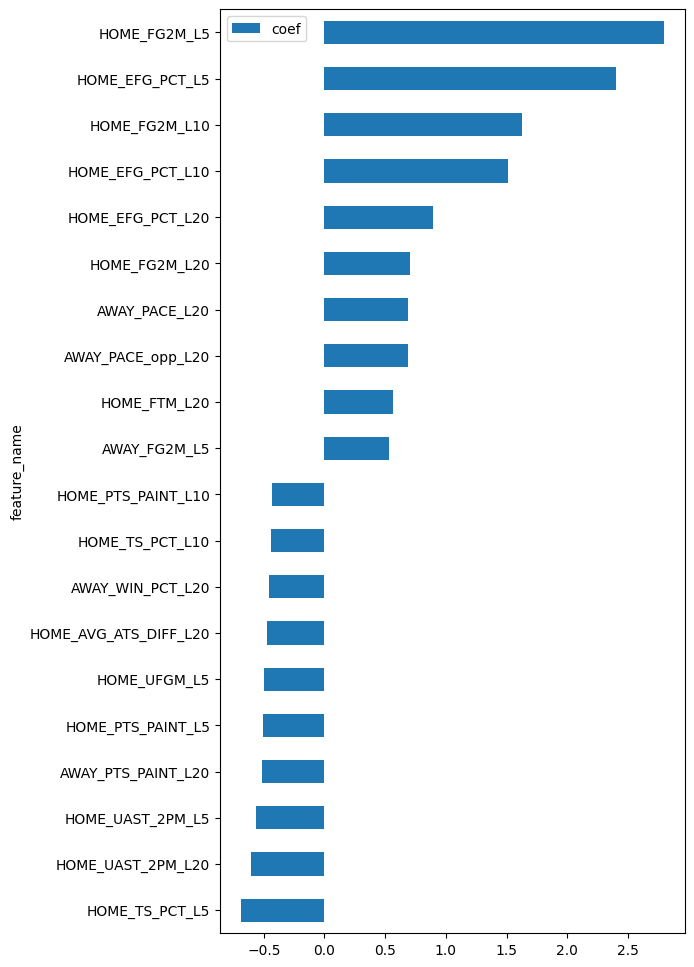

In [ ]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[0], X_train)

In [ ]:
sgd_coef_df.sort_values(['coef'], ascending=False)

,feature_name,coef
0,HOME_FG2M_L5,2.794521
87,HOME_EFG_PCT_L5,2.399840
94,HOME_FG2M_L10,1.628221
181,HOME_EFG_PCT_L10,1.514932
275,HOME_EFG_PCT_L20,0.896403
...,...,...
33,HOME_PTS_PAINT_L5,-0.504502
506,AWAY_PTS_PAINT_L20,-0.515164
36,HOME_UAST_2PM_L5,-0.566549
224,HOME_UAST_2PM_L20,-0.602828


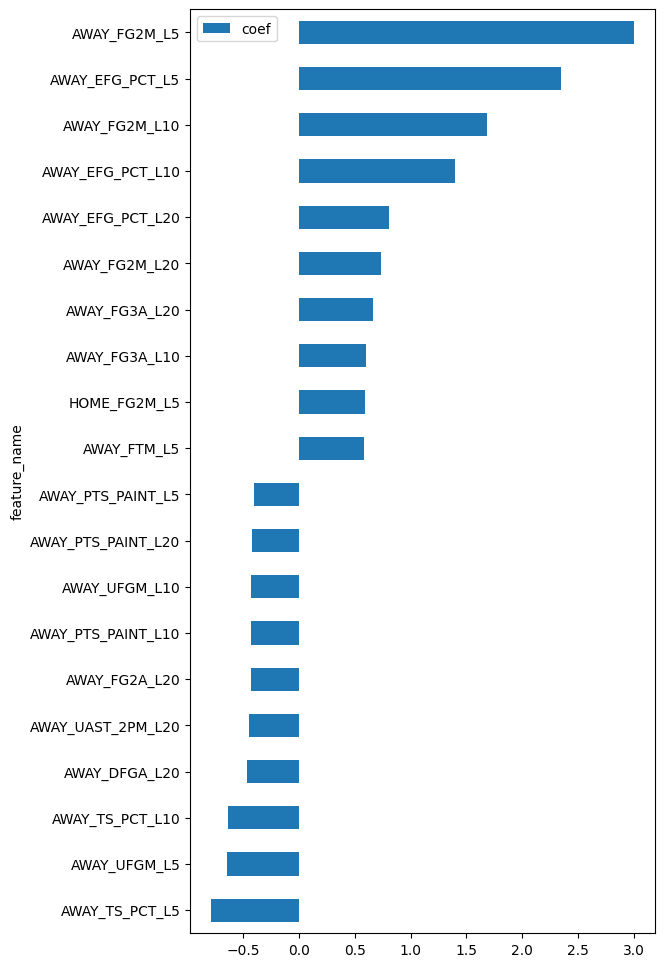

In [ ]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[1], X_train)

LGBoost or XGBoost


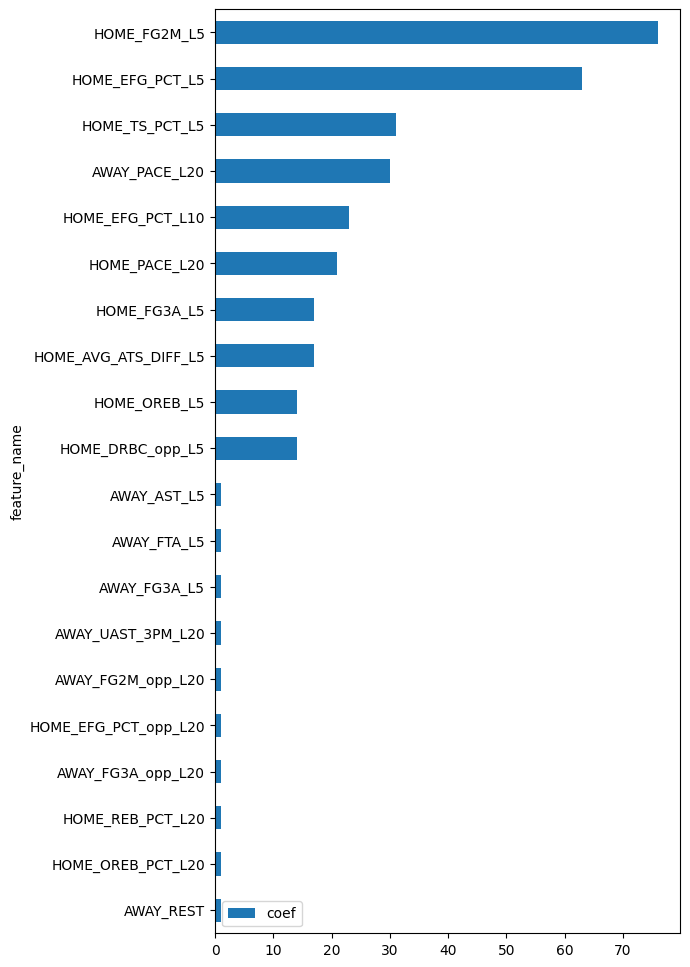

In [ ]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[0], X_train)

LGBoost or XGBoost


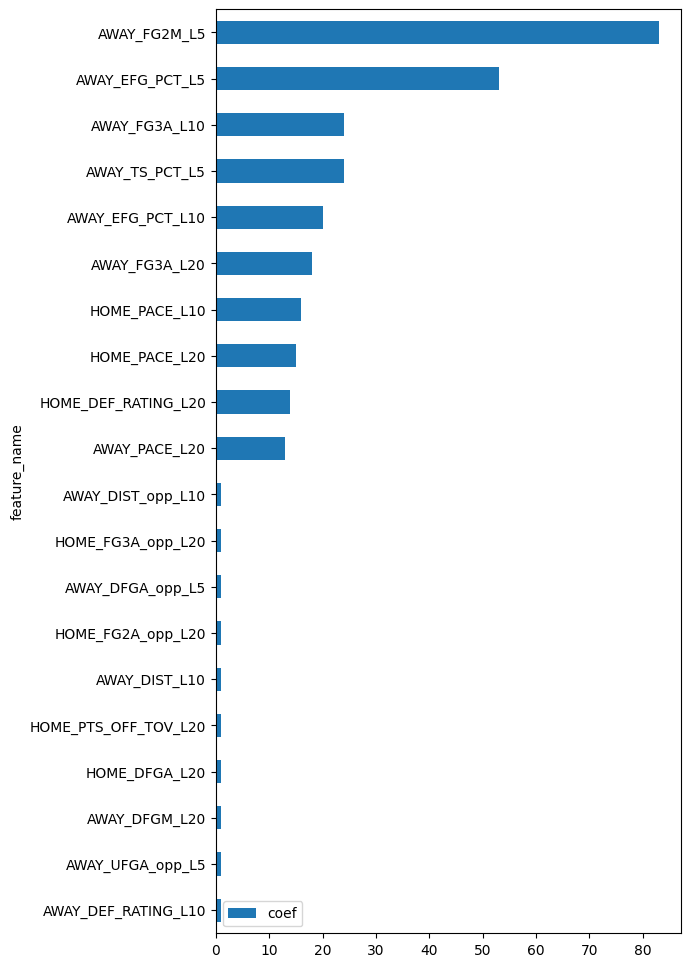

In [ ]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[1], X_train)